In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [19]:
class PIController:
    def __init__(self, kp, ki, dt):
        self.kp = kp
        self.ki = ki
        self.dt = dt
        self.integral = 0

    def control(self, error):
        self.integral += error * self.dt
        output = self.kp * error + self.ki * self.integral
        return output
    
class InductionMotor:
    def __init__(self, r_s, l_s, t_r, dt):
        self.r_s = r_s  # Stator resistance
        self.l_s = l_s  # Stator inductance
        self.t_r = t_r  # Rotor time constant
        self.dt = dt
        self.i_s_d = 0  # d-axis stator current
        self.i_s_q = 0  # q-axis stator current
        self.psi_r_d = 0  # d-axis rotor flux
        self.psi_r_q = 0  # q-axis rotor flux

    def update_currents(self, v_d, v_q):
        # Update rotor fluxes
        d_psi_r_d = v_d - self.r_s * self.i_s_d
        d_psi_r_q = v_q - self.r_s * self.i_s_q
        self.psi_r_d += d_psi_r_d * self.dt
        self.psi_r_q += d_psi_r_q * self.dt
        
        # Update stator currents
        di_s_d = (v_d - self.r_s * self.i_s_d - self.psi_r_d / self.t_r) / self.l_s
        di_s_q = (v_q - self.r_s * self.i_s_q - self.psi_r_q / self.t_r) / self.l_s
        self.i_s_d += di_s_d * self.dt
        self.i_s_q += di_s_q * self.dt
        
        return self.i_s_d, self.i_s_q

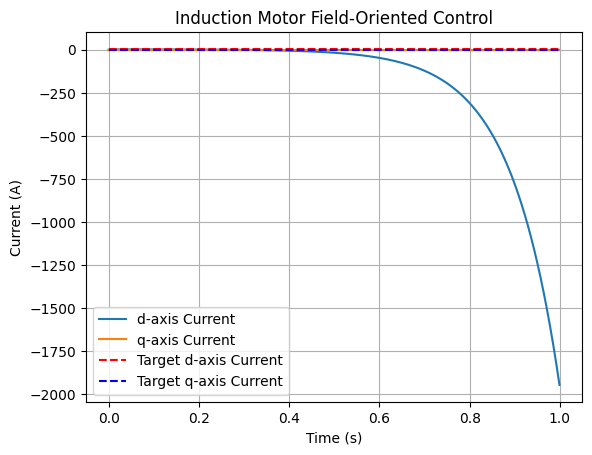

In [24]:
# Define motor parameters
r_s = 0.5  # Stator resistance (Ohm)
l_s = 0.01 # Stator inductance (H)
t_r = 0.1  # Rotor time constant (s)
dt = 0.001  # Time step (s)

# Create motor and PI controller instances
motor = InductionMotor(r_s, l_s, t_r, dt)
pi_d_controller = PIController(kp=0.5, ki=0.05, dt=dt)
pi_q_controller = PIController(kp=0.5, ki=0.05, dt=dt)

# Set target d-axis and q-axis currents
target_d_current = 5.0
target_q_current = 0.0
time = np.arange(0, 1, dt)

# Initial conditions
d_current_list = []
q_current_list = []

# Simulate the system
for t in time:
    error_d = target_d_current - motor.i_s_d
    error_q = target_q_current - motor.i_s_q
    
    control_signal_d = pi_d_controller.control(error_d)
    control_signal_q = pi_q_controller.control(error_q)
    
    motor_d_current, motor_q_current = motor.update_currents(control_signal_d, control_signal_q)
    
    d_current_list.append(motor_d_current)
    q_current_list.append(motor_q_current)

# Convert current lists to numpy arrays for plotting
d_current_list = np.array(d_current_list)
q_current_list = np.array(q_current_list)

# Plot results
plt.plot(time, d_current_list, label='d-axis Current')
plt.plot(time, q_current_list, label='q-axis Current')
plt.plot(time, [target_d_current]*len(time), 'r--', label='Target d-axis Current')
plt.plot(time, [target_q_current]*len(time), 'b--', label='Target q-axis Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Induction Motor Field-Oriented Control')
plt.legend()
plt.grid(True)
plt.show()